# SAM-GEO predict visualization

## Install dependencies

Uncomment and run the following cell to install the required dependencies.


In [ ]:
# %pip install segment-geospatial rasterio

In [10]:
# import sys
# # sys.path.append('/Users/huajunchen/Library/Project/Python/segment-geo/segment_geospatial_api')
# sys.path.append('.')  # Add current directory to path

import folium
from folium import plugins
import json
import rasterio
from rasterio.warp import transform_bounds
import asyncio
from pyproj import Transformer
import numpy as np

## import predict class

In [13]:
from pydantic import BaseModel, Field
from typing import Any, List, Optional, Union
class SegmentationWithTextPromptRequest(BaseModel):
    bounding_box: List[float] = Field(
        default=[-96.81040, 32.97140, -96.81000, 32.97180],
        description="Bounding box coordinates [west, south, east, north]",
        example=[-96.81040, 32.97140, -96.81000, 32.97180]
    )
    text_prompt: str = Field(
        default="trees",
        description="Text description of the features to detect",
        example="trees"
    )
    zoom_level: int = Field(
        default=19,
        description="Zoom level for satellite imagery (1-20), 20 may not work",
        ge=1,
        le=22
    )
    box_threshold: float = Field(
        default=0.24,
        description="Confidence threshold for object detection boxes (0-1)",
        ge=0,
        le=1
    )
    text_threshold: float = Field(
        default=0.24,
        description="Confidence threshold for text-to-image matching (0-1)",
        ge=0,
        le=1
    )

    class Config:
        json_schema_extra = {
            "example": {
                "bounding_box": [-96.81040, 32.97140, -96.81000, 32.97180],
                "text_prompt": "trees",
                "zoom_level": 19,
                "box_threshold": 0.24,
                "text_threshold": 0.24
            }
        }

from samgeo import raster_to_vector
from samgeo.text_sam import LangSAM
import uuid
import json
from typing import Dict, Any
import sys
import os
from pyproj import Transformer
from samgeo import tms_to_geotiff
import math
import itertools

def transform_coordinates(geojson_data):
    """Transform coordinates from EPSG:3857 to EPSG:4326"""
    if not geojson_data or 'features' not in geojson_data:
        return geojson_data

    for feature in geojson_data['features']:
        if 'geometry' not in feature:
            continue

        geometry = feature['geometry']
        if geometry['type'] == 'Polygon':
            for i, ring in enumerate(geometry['coordinates']):
                transformed_coords = []
                for x, y in ring:
                    lon, lat = self.transformer.transform(x, y)
                    transformed_coords.append([lon, lat])
                geometry['coordinates'][i] = transformed_coords
        elif geometry['type'] == 'MultiPolygon':
            for i, polygon in enumerate(geometry['coordinates']):
                for j, ring in enumerate(polygon):
                    transformed_coords = []
                    for x, y in ring:
                        lon, lat = self.transformer.transform(x, y)
                        transformed_coords.append([lon, lat])
                    geometry['coordinates'][i][j] = transformed_coords

    geojson_data['crs'] = {
        "type": "name",
        "properties": {
            "name": "urn:ogc:def:crs:EPSG::4326"
        }
    }
    return geojson_data

def download_satellite_image(image_name, bounding_box, zoom_level):
    """Download satellite image for the given bounding box and zoom level"""
    tms_to_geotiff(
        output=image_name,
        bbox=bounding_box,
        zoom=zoom_level,
        source="Satellite",
        overwrite=True
    )

def count_tiles(bounding_box, zoom_level):
    """Count the number of tiles needed for the given bounding box and zoom level.

    Args:
        bounding_box: The bounding box to count tiles for.
        zoom_level: The zoom level to count tiles for.

    Returns:
        The number of tiles needed for the given bounding box and zoom level.
    """
    def deg2num(lat, lon, zoom):
        lat_r = math.radians(lat)
        n = 2**zoom
        x_tile = (lon + 180) / 360 * n
        y_tile = (1 - math.log(math.tan(lat_r) + 1 / math.cos(lat_r)) / math.pi) / 2 * n
        return x_tile, y_tile

    # Convert bounding box coordinates to tile coordinates
    west, south, east, north = bounding_box
    x0, y0 = deg2num(south, west, zoom_level)
    x1, y1 = deg2num(north, east, zoom_level)

    x0, x1 = sorted([x0, x1])
    y0, y1 = sorted([y0, y1])
    corners = tuple(
        itertools.product(
            range(math.floor(x0), math.ceil(x1)),
            range(math.floor(y0), math.ceil(y1)),
        )
    )
    total_num = len(corners)
    return total_num

# Model Settings
DEFAULT_MODEL_TYPE = "sam2-hiera-large"

MAX_TILES_LIMIT = 1000

class TextPredictor:
    """Segmentation predictor class."""
    _instance = None
    _initialized = False

    def __new__(cls):
        """Create a new instance if one doesn't exist."""
        if cls._instance is None:
            cls._instance = super(TextPredictor, cls).__new__(cls)
        return cls._instance

    def __init__(self):
        """Empty init to maintain singleton pattern."""
        pass

    def setup(self, model_type=DEFAULT_MODEL_TYPE):
        """Initialize the LangSAM model.

        Args:
            model_type (str): The model type to use. Can be one of:
                SAM 1 models:
                - "vit_h"
                - "vit_l"
                - "vit_b"
                SAM 2 models:
                - "sam2-hiera-tiny"
                - "sam2-hiera-small"
                - "sam2-hiera-base-plus"
                - "sam2-hiera-large" (default)
        """
        print("Initializing LangSAM model...")

        try:
            print(f"\n[Loading Model] model_type: {model_type}")
            self._sam = LangSAM(model_type=model_type)

            self._initialized = True
            print("LangSAM model initialized successfully")
        except Exception as e:
            print(f"Failed to initialize LangSAM model: {str(e)}")
            raise RuntimeError(f"Failed to initialize LangSAM model: {str(e)}")

    @property
    def sam(self):
        """Get the SAM model instance, initializing with default model if needed.

        Returns:
            LangSAM: The initialized SAM model instance.

        Raises:
            RuntimeError: If model initialization fails.
        """
        if not self._initialized:
            self.setup()  # Initialize with default model
        return self._sam


        # Update CRS to WGS84
        geojson_data['crs'] = {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:EPSG::4326"
            }
        }
        return geojson_data

    def __del__(self):
        """Cleanup when instance is deleted."""
        if hasattr(self, '_sam'):
            print("Cleaning up TextPredictor instance")
            self._sam = None
            TextPredictor._initialized = False


    async def make_prediction(
        self,
        *,
        bounding_box: list,
        text_prompt: str,
        box_threshold: float = 0.3,
        text_threshold: float = 0.3,
        zoom_level: int = 20
    ) -> Dict[str, Any]:
        """Make a prediction using SAM.

        Args:
            bounding_box (list): Coordinates [west, south, east, north]
            text_prompt (str): Text description of object to detect
            box_threshold (float): Confidence threshold for object detection boxes (0-1)
            text_threshold (float): Confidence threshold for text-to-image matching (0-1)
            zoom_level (int, optional): Zoom level for satellite imagery. Defaults to 20.
        """
        print(
            f"Starting prediction for text_prompt='{text_prompt}', "
            f"bbox={bounding_box}, zoom={zoom_level}, "
            f"box_threshold={box_threshold}, text_threshold={text_threshold}"
        )
        # Validate thresholds
        if not (0 < box_threshold <= 1) or not (0 < text_threshold <= 1):
            print(f"[Error] Invalid threshold values: box={box_threshold}, text={text_threshold}")
            return {"error": "Threshold values must be between 0 and 1"}

        # Validate inputs
        if len(bounding_box) != 4:
            print(f"[Error] Invalid bounding box length: {len(bounding_box)}")
            return {"error": "Bounding box must contain exactly 4 coordinates [west, south, east, north]"}


        # Check number of tiles
        total_tiles = count_tiles(bounding_box, zoom_level)
        if total_tiles > MAX_TILES_LIMIT:
            print(f"[Error] Number of tiles exceeds the maximum limit: {total_tiles}")
            return {"error": f"Number of tiles exceeds the maximum limit: {total_tiles}"}
        else:
            print(f"[Info] Number of tiles to download: {total_tiles}")
        # Generate unique filenames
        request_id = str(uuid.uuid4())
        print(f"[Info] Generated request ID: {request_id}")
        input_image = f"satellite_{request_id}.tif"
        output_image = f"segment_{request_id}.tif"
        output_geojson = f"segment_{request_id}.geojson"

        try:
            # Download satellite imagery
            print("\n[Download] Downloading satellite imagery...")
            try:
                download_satellite_image(
                    input_image,
                    bounding_box,
                    zoom_level
                )
                print("[Download] Satellite imagery downloaded successfully")
            except Exception as e:
                print(f"[Error] Failed to download satellite imagery: {str(e)}")
                raise Exception("Failed to download satellite imagery: `{str(e)}`")

            # Run prediction
            print("\n[Predict] Running SAM prediction...")
            try:
                self.sam.predict(
                    input_image,
                    text_prompt,
                    box_threshold,
                    text_threshold
                )
                print("[Predict] SAM prediction completed successfully")
            except Exception:
                print("[Error] Failed to run SAM prediction")
                raise Exception("Failed to run SAM prediction: `{str(e)}`")

            # Generate visualization
            print("\n[Info] Generating visualization...")
            try:
                self.sam.show_anns(
                    cmap="Greys_r",
                    add_boxes=False,
                    alpha=1,
                    title=f"Automatic Segmentation of {text_prompt}",
                    blend=False,
                    output=output_image,
                )
                print("[Info] Visualization generated successfully")
            except Exception:
                print("[Error] Failed to generate visualization")
                raise

            # Convert to GeoJSON
            try:
                raster_to_vector(output_image, output_geojson, None)
                print("[Convert] GeoJSON converted successfully")
            except Exception as e:
                print(f"[Error] Failed to convert to GeoJSON: No vector data found in the image")
                raise Exception("No vector data found in the image")

            # Read and process GeoJSON
            try:
                with open(output_geojson, 'r') as f:
                    geojson_content = json.load(f)
                print(f"[Process] Loaded GeoJSON with {len(geojson_content.get('features', []))} features")

                transformed_geojson = transform_coordinates(geojson_content)
                geojson_count = len(transformed_geojson.get('features', []))
                print(f"[Process] Transformed {geojson_count} features to WGS84")

                return {
                    "errors": None,
                    "version": "1.0",
                    "predictions": f"Successfully found {geojson_count} features",
                    "geojson": transformed_geojson
                }

            except Exception as e:
                print(f"[Error] Failed to process GeoJSON: {str(e)}")
                raise

        except Exception as e:
            print(f"\n[Error] Exception occurred: {str(e)}")
            return {"error": str(e)}

        finally:
            # Clean up temporary files
            print("\n[Cleanup] Removing temporary files...")
            for file in [input_image, output_image, output_geojson]:
                if os.path.exists(file):
                    try:
                        os.remove(file)
                        print(f"[Cleanup] Removed: {file}")
                    except Exception as e:
                        print(f"[Cleanup] Failed to remove {file}: {str(e)}")


# Create singleton instance
textPredictor = TextPredictor()
textPredictor.setup()

Initializing LangSAM model...

[Loading Model] model_type: vit_b


GroundingDINO_SwinB.cfg.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Failed to initialize LangSAM model: name 'SLConfig' is not defined


RuntimeError: Failed to initialize LangSAM model: name 'SLConfig' is not defined

In [ ]:
zoom_level = 21

# research suggested to use low box_threshold for trees(irregular shape) and high box_threshold for buildings(regular shape)
text_prompts = [
    PromptConfig(
        value='buildings',
        box_threshold=0.27,
        text_threshold=0.25,
    )]

In [ ]:
def get_bounding_box(points, buffer_meters=0, lat_first=True):
    """
    Calculate bounding box from points with buffer in meters
    Args:
        points: List of points, either [lat, lon] or [lon, lat]
        buffer_meters: Buffer distance in meters
        lat_first: True if points are [lat, lon], False if [lon, lat]
    Returns:
        [west, south, east, north] bounding box
    """
    points = np.array(points)

    to_meters = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    to_latlon = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)

    # Handle coordinate order
    if lat_first:
        # Convert [lat, lon] to [lon, lat] for transformation
        points_meters = np.array([to_meters.transform(lon, lat) for lat, lon in points])
    else:
        # Points already in [lon, lat] order
        points_meters = np.array([to_meters.transform(x, y) for x, y in points])

    # Calculate bounds with buffer
    min_x = np.min(points_meters[:, 0]) - buffer_meters
    max_x = np.max(points_meters[:, 0]) + buffer_meters
    min_y = np.min(points_meters[:, 1]) - buffer_meters
    max_y = np.max(points_meters[:, 1]) + buffer_meters

    # Convert back to lat/lon
    west, south = to_latlon.transform(min_x, min_y)
    east, north = to_latlon.transform(max_x, max_y)

    return [west, south, east, north]


In [ ]:
bbox1 = [
-76.16560917169102,
43.046243663472765,
-76.1636565235279,
43.047411911551116,
]

# 443 n Franklin st ny
pnt1 = [43.056885896731835, -76.15662029288724]
pnt2 = [43.055749186935905, -76.15706017514376]
bbox2 = get_bounding_box([pnt1, pnt2], buffer_meters=0, lat_first=True)

bbox = bbox2





In [ ]:
zoom_level = 21

# research suggested to use low box_threshold for trees(irregular shape) and high box_threshold for buildings(regular shape)
text_prompts = [
    PromptConfig(
        value='buildings',
        box_threshold=0.27,
        text_threshold=0.25,
    )]

2025-02-24 09:49:49.497 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:223 - Starting prediction bbox=[-76.15706017514376, 43.055749186935905, -76.15662029288724, 43.056885896731835], zoom=21
2025-02-24 09:49:49.501 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:237 - Number of tiles to download: 40
2025-02-24 09:49:49.502 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:245 - Generated request ID: 7e53c44b-2f57-4800-aad7-0592a75455b3
2025-02-24 09:49:49.502 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:252 - Downloading satellite imagery...


Downloaded image 01/40
Downloaded image 02/40
Downloaded image 03/40
Downloaded image 04/40
Downloaded image 05/40
Downloaded image 06/40
Downloaded image 07/40
Downloaded image 08/40
Downloaded image 09/40
Downloaded image 10/40
Downloaded image 11/40
Downloaded image 12/40
Downloaded image 13/40
Downloaded image 14/40
Downloaded image 15/40
Downloaded image 16/40
Downloaded image 17/40
Downloaded image 18/40
Downloaded image 19/40
Downloaded image 20/40
Downloaded image 21/40
Downloaded image 22/40
Downloaded image 23/40
Downloaded image 24/40
Downloaded image 25/40
Downloaded image 26/40
Downloaded image 27/40
Downloaded image 28/40
Downloaded image 29/40
Downloaded image 30/40
Downloaded image 31/40
Downloaded image 32/40
Downloaded image 33/40
Downloaded image 34/40
Downloaded image 35/40
Downloaded image 36/40
Downloaded image 37/40
Downloaded image 38/40
Downloaded image 39/40
Downloaded image 40/40
Saving GeoTIFF. Please wait...


2025-02-24 09:49:50.815 | SUCCESS  | notebook.predict_jan_2025.predict_jan_2025:make_predictions:259 - Satellite imagery downloaded successfully
2025-02-24 09:49:50.816 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:265 - Running SAM prediction...
2025-02-24 09:49:50.816 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:279 - Running SAM prediction for buildings, box_threshold=0.27, text_threshold=0.25


Image saved to satellite_7e53c44b-2f57-4800-aad7-0592a75455b3.tif


2025-02-24 09:50:01.872 | SUCCESS  | notebook.predict_jan_2025.predict_jan_2025:make_predictions:287 - SAM prediction completed successfully
2025-02-24 09:50:01.874 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:294 - Generating visualization...
2025-02-24 09:50:01.896 | SUCCESS  | notebook.predict_jan_2025.predict_jan_2025:make_predictions:304 - Visualization generated successfully
2025-02-24 09:50:01.897 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:310 - Converting to GeoJSON...
2025-02-24 09:50:01.941 | SUCCESS  | notebook.predict_jan_2025.predict_jan_2025:make_predictions:313 - Converted to GeoJSON successfully
2025-02-24 09:50:01.941 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:319 - Reading GeoJSON content...
2025-02-24 09:50:01.943 | INFO     | notebook.predict_jan_2025.predict_jan_2025:make_predictions:329 - Transforming coordinates to WGS84...
2025-02-24 09:50:01.944 | SUCCESS  | notebook.predict

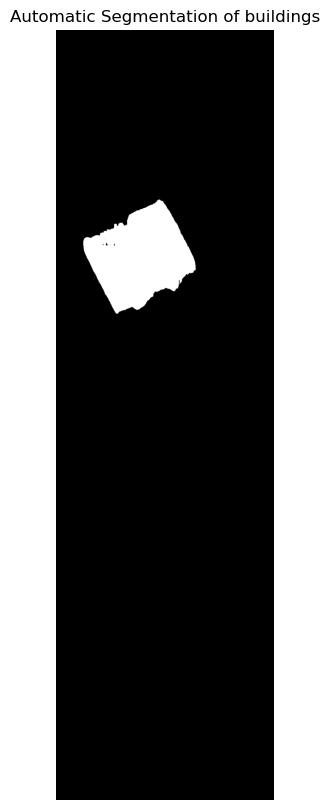

In [ ]:
async def run_prediction():
    result = await predictor.make_predictions(
        bounding_box=bbox,
        text_prompts=text_prompts,
        zoom_level=zoom_level,
    )
    return result

result = await run_prediction()

In [ ]:
# 创建基础地图,
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=19,
    tiles='CartoDB positron',
)

# 添加卫星图层,
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Satellite',
).add_to(m)

# 添加预测结果,
if result.get('geojson'):
    for idx, geojson_data in enumerate(result['geojson']):
        folium.GeoJson(
            geojson_data,
            name=f'Prediction {idx+1}',
            style_function=lambda x: {
                'fillColor': '#ff7800',
                'color': '#ff7800',
                'weight': 2,
                'fillOpacity': 0.4,
            },
        ).add_to(m)

# 添加图层控制,
folium.LayerControl().add_to(m)

# 显示地图,
m